In [74]:
# import sys
# !{sys.executable} -m pip install yfinance 
# !{sys.executable} -m pip install yahoofinancials
# !{sys.executable} -m pip install plotly
# !{sys.executable} -m pip install statsmodels

import os
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels import regression
from yahoofinancials import YahooFinancials
from plotly.subplots import make_subplots

In [2]:
# Set working directory
cwd = os.getcwd()
os.chdir(os.path.abspath(os.path.join(cwd, os.pardir)))

cwd = os.getcwd() 
print("Current Directory", cwd)

Current Directory /Users/administrator/Desktop/shenghao-repos/simple-funds-screener


# I. Load ETF List
The list of ETF of US market was obtained from ETFdb.com

### https://etfdb.com/etfs/country/us/

In [4]:
etf_df = pd.read_csv('etfdb/etfs_details_type_fund_flow.csv')
print(etf_df.shape)

etf_df.head().T

(1509, 54)


,0,1,2,3,4
Symbol,SPY,IVV,VTI,VOO,QQQ
ETF Name,SPDR S&P 500 ETF,iShares Core S&P 500 ETF,Vanguard Total Stock Market ETF,Vanguard S&P 500 ETF,Invesco QQQ
Asset Class,Equity,Equity,Equity,Equity,Equity
Total Assets,"$281,869,540,479.00","$206,686,119,420.00","$156,436,675,575.00","$154,869,718,010.00","$125,291,793,266.00"
YTD Price Change,1.95%,1.93%,1.80%,1.91%,25.49%
Avg. Daily Volume,"71,056,104","3,584,791","3,083,852","3,373,643","45,714,640"
Previous Closing Price,$323.50,$324.60,$164.99,$298.50,$265.39
1-Day Change,0.27%,0.26%,0.21%,0.28%,0.47%
Inverse,No,No,No,No,No
Leveraged,No,No,No,No,No


In [5]:
etf_df['Asset Class'].value_counts()

Equity             978
Bond               354
Multi-Asset         81
Real Estate         32
Alternatives        24
Preferred Stock     13
Volatility          13
Currency             4
Name: Asset Class, dtype: int64

In [6]:
etf_df['ETFdb.com Category'].value_counts()

Large Cap Growth Equities            222
Leveraged Equities                   101
Large Cap Blend Equities              95
All Cap Equities                      89
Total Bond Market                     77
Corporate Bonds                       69
High Yield Bonds                      63
Small Cap Blend Equities              51
Small Cap Growth Equities             50
National Munis                        47
Europe Equities                       44
Diversified Portfolio                 37
Technology Equities                   37
Government Bonds                      37
Health & Biotech Equities             37
Financials Equities                   28
Real Estate                           26
Small Cap Value Equities              24
Energy Equities                       22
Large Cap Value Equities              19
Long-Short                            19
Hedge Fund                            18
Preferred Stock/Convertible Bonds     18
Global Equities                       18
Industrials Equi

# II. Download Historical Data

In [7]:
spy_df = yf.download(
    'SPY', 
    start='2010-01-01', 
    end='2019-12-31', 
    progress=False
).reset_index()

print(spy_df.shape)
spy_df.head()

(2516, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,112.769997,112.800003,111.389999,111.440002,89.950172,90637900
1,2010-01-04,112.370003,113.389999,111.510002,113.330002,91.475693,118944600
2,2010-01-05,113.260002,113.680000,112.849998,113.629997,91.717857,111579900
3,2010-01-06,113.519997,113.989998,113.430000,113.709999,91.782425,116074400
4,2010-01-07,113.500000,114.330002,113.180000,114.190002,92.169884,131091100


In [10]:
combined_df = pd.DataFrame()
funds = ['SPY', 'IVV', 'VTI', 'VOO', 'QQQ']

for fund in funds:
    df = yf.download(
        fund, 
        start='2010-01-01', 
        end='2019-12-31', 
        progress=False
    ).reset_index()
    df = df[['Date', 'Adj Close']]
    df.rename(columns={'Adj Close': fund}, inplace=True)
    if combined_df.shape[0] == 0:
        combined_df = df
    else:
        combined_df = combined_df.merge(df, how='left', on='Date')

print(combined_df.shape)
combined_df.head()

(2516, 6)


,Date,SPY,IVV,VTI,VOO,QQQ
0,2009-12-31,89.950172,89.831673,45.801785,NaN,41.045174
1,2010-01-04,91.475693,91.310020,46.565559,NaN,41.646263
2,2010-01-05,91.717857,91.575150,46.744320,NaN,41.646263
3,2010-01-06,91.782425,91.647453,46.809322,NaN,41.395069
4,2010-01-07,92.169884,92.049149,47.004326,NaN,41.421986


In [12]:
combined_df.isna().sum() / combined_df.shape[0]

Date    0.00000
SPY     0.00000
IVV     0.00000
VTI     0.00000
VOO     0.06876
QQQ     0.00000
dtype: float64

# III. Visualize Price Variation

In [13]:
combined_df = combined_df.set_index('Date')
combined_df.head()

,SPY,IVV,VTI,VOO,QQQ
Date,,,,,
2009-12-31,89.950172,89.831673,45.801785,NaN,41.045174
2010-01-04,91.475693,91.310020,46.565559,NaN,41.646263
2010-01-05,91.717857,91.575150,46.744320,NaN,41.646263
2010-01-06,91.782425,91.647453,46.809322,NaN,41.395069
2010-01-07,92.169884,92.049149,47.004326,NaN,41.421986


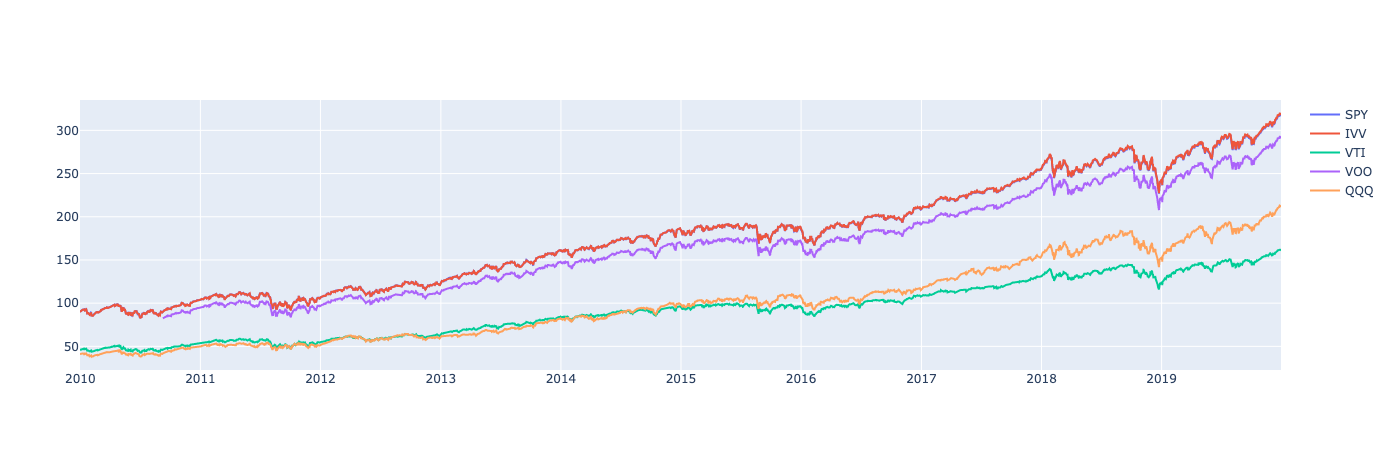

In [20]:
import plotly.graph_objects as go


# Create traces
fig = go.Figure()
for fund in funds:
    fig.add_trace(
        go.Scatter(
            x=combined_df.index, y=combined_df[fund],
            mode='lines',
            name=fund
    ))

fig.show()

# IV. Volatility - Beta Coefficient

Beta is a measure used in fundamental analysis to determine the volatility of an asset or portfolio in relation to the overall market. The overall market has a beta of 1.0, and individual stocks are ranked according to how much they deviate from the market.

A stock that swings more than the market over time has a beta greater than 1.0. If a stock moves less than the market, the stock's beta is less than 1.0. High-beta stocks tend to be riskier but provide the potential for higher returns. Low-beta stocks pose less risk but typically yield lower returns. As a result, beta is often used as a risk-reward measure, meaning it helps investors determine how much risk they are willing to take to achieve the return for taking on that risk.



### Beta = Covariance / Variance
<ul>
    <li>Covariance measures how two stocks move together. A positive covariance means the stocks tend to move together when their prices go up or down. A negative covariance means the stocks move opposite of each other.</li>
    <li>Variance, on the other hand, refers to how far a stock moves relative to its mean. For example, variance is used in measuring the volatility of an individual stock's price over time. Covariance is used to measure the correlation in price moves of two different stocks.</li>
    <li>Covariance = Measure of a stock’s return relative to that of the market</li>
    <li>Variance = Measure of how the market moves relative to its mean</li>
</ul>

## 4.1 Take S&P500 ETF as benchmark

In [57]:
benchmark_df = combined_df[['SPY']].reset_index()
benchmark_df.head()

,Date,SPY
0,2009-12-31,89.950172
1,2010-01-04,91.475693
2,2010-01-05,91.717857
3,2010-01-06,91.782425
4,2010-01-07,92.169884


In [56]:
aapl_df = yf.download(
    'AAPL', 
    start='2010-01-01', 
    end='2020-10-01', 
    progress=False
).reset_index()

aapl_df = aapl_df[['Date', 'Adj Close']]
aapl_df.rename(columns={'Adj Close': 'AAPL'}, inplace=True)
print(aapl_df.shape)
aapl_df.head()

(2706, 2)


,Date,AAPL
0,2009-12-31,6.503574
1,2010-01-04,6.604801
2,2010-01-05,6.616219
3,2010-01-06,6.510980
4,2010-01-07,6.498945


In [58]:
aapl_df.tail()

,Date,AAPL
2701,2020-09-24,108.220001
2702,2020-09-25,112.279999
2703,2020-09-28,114.959999
2704,2020-09-29,114.089996
2705,2020-09-30,115.809998


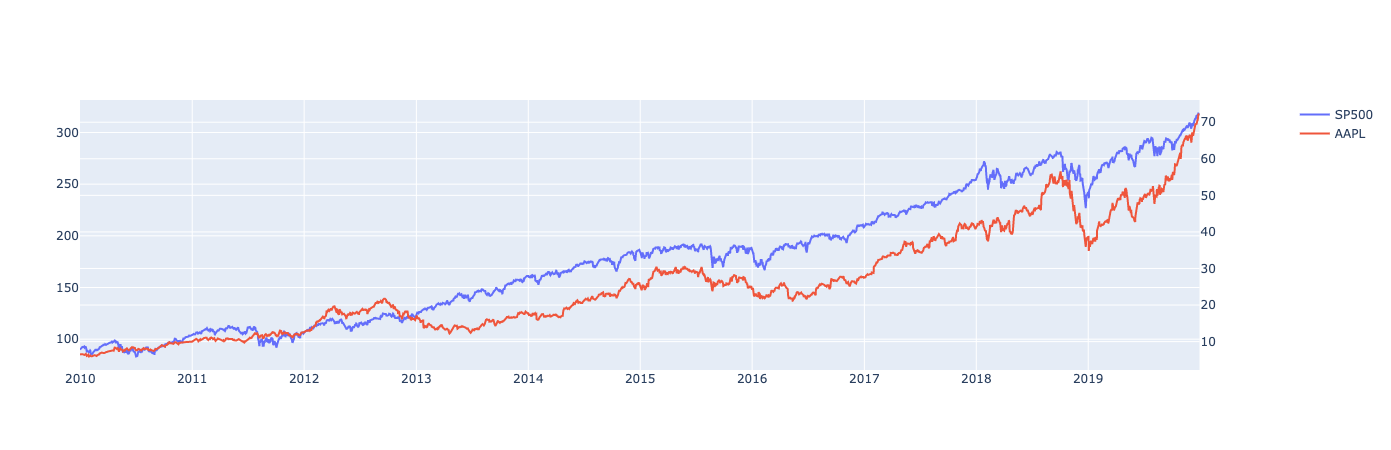

In [59]:
from plotly.subplots import make_subplots


tmp_df = benchmark_df.merge(aapl_df, how='left', on='Date')
tmp_df = tmp_df.set_index('Date')

# Create traces
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(
        x=tmp_df.index, y=tmp_df['SPY'],
        mode='lines',
        name='SP500'
    ),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(
        x=tmp_df.index, y=tmp_df['AAPL'],
        mode='lines',
        name='AAPL'),
    secondary_y=True
)

fig.show()

## 4.2 Calculate daily return

In [61]:
daily_return = (tmp_df['SPY']/ tmp_df['SPY'].shift(1)) - 1, 
daily_return_df = daily_return[0].to_frame()
daily_return_df['AAPL'] = (tmp_df['AAPL'] / tmp_df['AAPL'].shift(1)) - 1
daily_return_df

,SPY,AAPL
Date,,
2009-12-31,NaN,NaN
2010-01-04,0.016960,0.015565
2010-01-05,0.002647,0.001729
2010-01-06,0.000704,-0.015906
2010-01-07,0.004221,-0.001848
...,...,...
2019-12-23,0.001528,0.016318
2019-12-24,0.000031,0.000951
2019-12-26,0.005323,0.019840


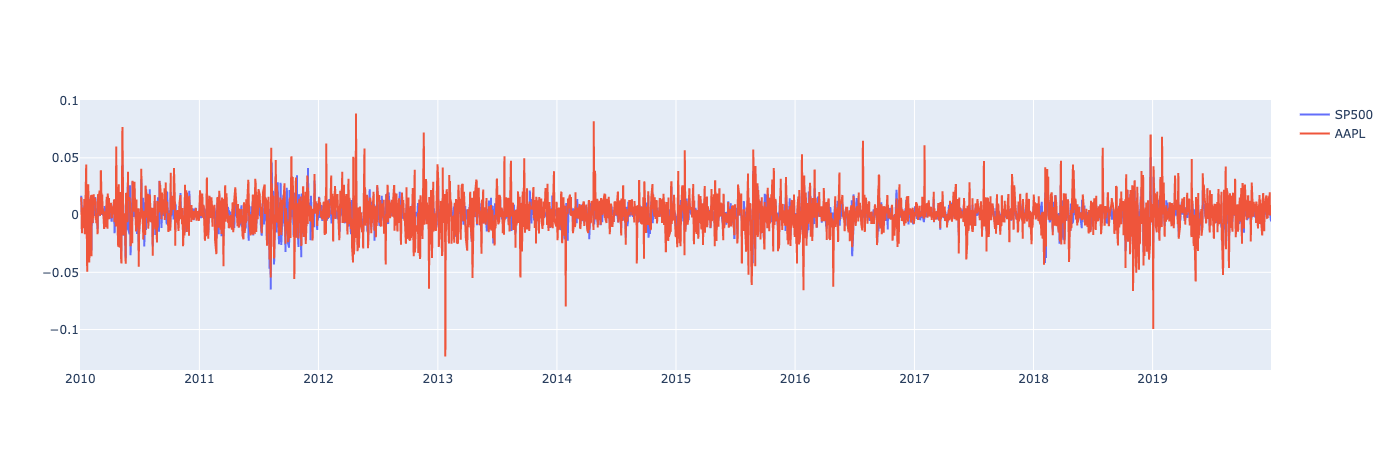

In [62]:
# Create traces
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=daily_return_df.index,
        y=daily_return_df['SPY'],
        mode='lines',
        name='SP500'
    )
)

fig.add_trace(
    go.Scatter(
        x=daily_return_df.index,
        y=daily_return_df['AAPL'],
        mode='lines',
        name='AAPL')
)

fig.show()

## 4.3 Calculate beta

In [64]:
daily_return_df.cov()

,SPY,AAPL
SPY,0.000086,0.000089
AAPL,0.000089,0.000263


In [76]:
daily_return_df.var()

SPY     0.000086
AAPL    0.000263
dtype: float64

In [78]:
beta = 0.000089 / 0.000086
beta

1.0348837209302324

In [72]:
daily_return_df.isna().sum() / daily_return_df.shape[0]

SPY     0.000397
AAPL    0.000397
dtype: float64

In [81]:
daily_return_df = daily_return_df.dropna()
X = daily_return_df['SPY'].values
Y = daily_return_df['AAPL'].values

def linreg(x, y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X, Y)
print(f"alpha: {round(alpha*100, 4)}%")
print(f"beta: {round(beta, 4)}")

alpha: 0.0525%
beta: 1.041


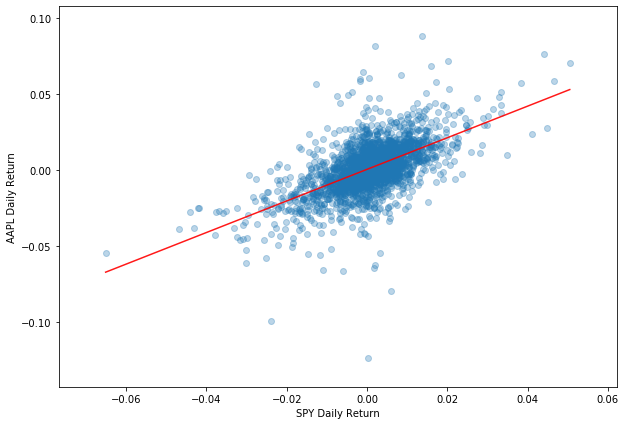

In [75]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

plt.figure(figsize=(10, 7))
plt.scatter(X, Y, alpha=0.3) # Plot the raw data
plt.xlabel("SPY Daily Return")
plt.ylabel("AAPL Daily Return")
plt.plot(X2, Y_hat, 'r', alpha=0.9)
plt.show()

# V. Sharpe Ratio

In [86]:
annual_sharpe_ratio = daily_return_df['SPY'].mean() / daily_return_df['SPY'].std() * (252 ** 0.5)
print(f"Annual sharpe ratio of SPY: {round(annual_sharpe_ratio, 4)}")

annual_sharpe_ratio = daily_return_df['AAPL'].mean() / daily_return_df['AAPL'].std() * (252 ** 0.5)
print(f"Annual sharpe ratio of AAPL: {round(annual_sharpe_ratio, 4)}")

Annual sharpe ratio of SPY: 0.9314
Annual sharpe ratio of AAPL: 1.0669


# References

### The Formula for Calculating Beta
https://www.investopedia.com/ask/answers/070615/what-formula-calculating-beta.asp

### Asset Beta & Market Beta In Python
https://blog.quantinsti.com/asset-beta-market-beta-python/

### Use Python to calculate the Sharpe ratio for a portfolio
https://towardsdatascience.com/calculating-sharpe-ratio-with-python-755dcb346805